# Machine Learning for Basketball Memorabilia Investments
In this assignment you will use real data on past basketball players to use ML to inform memorabilia investmentdecisions.

You are provided with data on past players that includes 27 different predictors/attributes on each player. Note that the attribute names are often abbreviated and the complete list is included at the end of this notebook.

You will use the historical data set, Hall-of-fame-train.arff (495 players), to build a classification model predicting whether or not a given player will be inducted (and the probability thereof). You will then apply your model to
select players to invest in. The goal of this assignment is to develop hands-on experience in developing and evaluating machine learning models to inform interventions (investment decisions in this case) and to maximize profitability.

The data set includes a target variable (i.e., the class) which indicates whether or not the player has been inducted to the hall of fame. Note that in this data set, we assume that a player who has not been inducted 45.4 years after retirement, will not be inducted. The target variable is binary and has value 1 if the player has been inducted or 0 otherwise. Note that the data includes the actual target variable value for each player. This information is available for this assignment in order to allow you to evaluate the efficacy of investment decisions and to compare amongst investments selected by different models to identify the best model to use in the future.

## 1. Read in Libraries and NBA data

(run these cells before starting)

In [188]:
# import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import requests
import arff
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, confusion_matrix,accuracy_score, roc_curve, auc # plot evaluations
from sklearn.model_selection import cross_val_score, cross_val_predict

import warnings
warnings.filterwarnings("ignore")

In [189]:
# get data from online
df_arff = requests.get('https://utexas.box.com/shared/static/u8s1nl2c8b3ijv94z7npg7jl0drml5u0.arff')

# read as arff file
df_arff = arff.load(df_arff.text)
col_val = [attribute[0] for attribute in df_arff['attributes']]

# transform arff file into pandas dataframe
new_df = pd.DataFrame(df_arff['data'], columns = col_val)
meta = df_arff['attributes']

def clean_df(df):
    cols= list(df.columns)
    for col in cols:
        try:
            df = df.replace({col: {'1': True, '0': False}})
        except:
            pass
        pass
    return df

new_df = clean_df(new_df)
new_df = pd.get_dummies(new_df)

In [190]:
new_df

,games,minutes,pts,offReb,defReb,reb,asts,stl,blk,turnover,...,firstSeason,lastSeason,careerEnded,yrsRetired2004,class,league_A,league_N,Position_C,Position_F,Position_G
0,408.0,9825.0,5232.0,476.0,824.0,1300.0,866.0,265.0,175.0,700.0,...,1982.0,1990.0,1.0,14.0,False,0,1,0,0,1
1,51.0,0.0,587.0,0.0,0.0,0.0,158.0,0.0,0.0,0.0,...,1949.0,1949.0,1.0,55.0,False,0,1,0,0,1
2,265.0,0.0,1712.0,0.0,0.0,72.0,311.0,0.0,0.0,0.0,...,1946.0,1950.0,1.0,54.0,False,0,1,0,0,1
3,133.0,2587.0,992.0,55.0,198.0,253.0,291.0,123.0,14.0,207.0,...,2003.0,2004.0,0.0,0.0,False,0,1,0,0,1
4,8.0,28.0,7.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,...,2004.0,2004.0,0.0,0.0,False,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,262.0,5229.0,2508.0,214.0,468.0,682.0,507.0,319.0,101.0,289.0,...,1976.0,1979.0,1.0,25.0,False,0,1,0,0,1
491,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1946.0,1946.0,1.0,58.0,False,0,1,0,1,0
492,814.0,19241.0,9948.0,140.0,282.0,4555.0,1112.0,89.0,16.0,0.0,...,1963.0,1974.0,1.0,30.0,False,0,1,0,1,0
493,98.0,1220.0,345.0,71.0,248.0,319.0,48.0,27.0,42.0,85.0,...,2000.0,2002.0,1.0,2.0,False,0,1,0,1,0


## 2. Exploring the Data

### 2.1 Building, Evaluating, and Comparing Different Machine Learning Models (5 points)

**IMPORTANT: When training these models you MUST use `random_state=3` on each of the classifiers and Naive Bayes. Failure to do so will be (-5 points)**

In [191]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

X = new_df.drop(columns='class')
y = new_df['class']

dt_model = DecisionTreeClassifier(random_state = 3).fit(X, y)
bagging_model = BaggingClassifier(random_state = 3).fit(X, y)
rf_model = RandomForestClassifier(random_state = 3).fit(X, y)
nb_model = MultinomialNB().fit(X, y)
knn_model = KNeighborsClassifier().fit(X, y)

# Define the models
models = [dt_model, bagging_model, rf_model, nb_model, knn_model]

# Initialize lists to store results
accuracy_scores = []
roc_auc_scores = []

# Perform 10-fold cross-validation for each model
for model in models:
    # Accuracy scores
    accuracy = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    accuracy_scores.append(accuracy.mean())
    
    # ROC AUC scores
    roc_auc = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
    roc_auc_scores.append(roc_auc.mean())

# Display the results
for i, model in enumerate(models):
    print(f"Model {model}:")
    print(f"Accuracy Score (mean): {accuracy_scores[i]:.4f}")
    print(f"ROC AUC Score (mean): {roc_auc_scores[i]:.4f}")
    print()

Model DecisionTreeClassifier(random_state=3):
Accuracy Score (mean): 0.9616
ROC AUC Score (mean): 0.8864

Model BaggingClassifier(random_state=3):
Accuracy Score (mean): 0.9697
ROC AUC Score (mean): 0.9576

Model RandomForestClassifier(random_state=3):
Accuracy Score (mean): 0.9737
ROC AUC Score (mean): 0.9646

Model MultinomialNB():
Accuracy Score (mean): 0.8867
ROC AUC Score (mean): 0.8939

Model KNeighborsClassifier():
Accuracy Score (mean): 0.9697
ROC AUC Score (mean): 0.9106



In [192]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# Hyperparameter grid for Bagging Classifier
bagging_param_grid = {
    'n_estimators': [10, 50, 100, 200, 300]
}

# Hyperparameter grid for Multinomial Naive Bayes
nb_param_grid = {
    'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'fit_prior': [True, False]
}

# Hyperparameter grid for K-Nearest Neighbors
knn_param_grid = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30],
    'weights': ['uniform', 'distance']
}

# Grid search for Bagging Classifier
bagging_grid_search = GridSearchCV(
    BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=3), random_state=3),
    bagging_param_grid,
    cv=10,
    scoring='roc_auc'
)
bagging_grid_search.fit(X, y)

# Grid search for K-Nearest Neighbors
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='roc_auc')
knn_grid_search.fit(X, y)

# Grid search for Multinomial Naive Bayes
nb_grid_search = GridSearchCV(MultinomialNB(), nb_param_grid, cv=10, scoring='roc_auc')
nb_grid_search.fit(X, y)

# Grid search for Decision Tree
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=3), dt_param_grid, cv=10, scoring='roc_auc')
dt_grid_search.fit(X, y)

# Grid search for Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=3), rf_param_grid, cv=10, scoring='roc_auc')
rf_grid_search.fit(X, y)

# Best hyperparameters for Decision Tree
print("Best Parameters for Decision Tree:", dt_grid_search.best_params_)

# Best hyperparameters for Random Forest
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)

# Best hyperparameters for Bagging Classifier
print("Best Parameters for Bagging Classifier:", bagging_grid_search.best_params_)

# Best hyperparameters for Multinomial Naive Bayes
print("Best Parameters for Multinomial Naive Bayes:", nb_grid_search.best_params_)

# Best hyperparameters for K-Nearest Neighbors
print("Best Parameters for K-Nearest Neighbors:", knn_grid_search.best_params_)

Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 2}
Best Parameters for Random Forest: {'max_features': 6, 'n_estimators': 100}
Best Parameters for Bagging Classifier: {'n_estimators': 10}
Best Parameters for Multinomial Naive Bayes: {'alpha': 1, 'fit_prior': True}
Best Parameters for K-Nearest Neighbors: {'n_neighbors': 8, 'weights': 'uniform'}


In [193]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

X = new_df.drop(columns='class')
y = new_df['class']

dt_model = DecisionTreeClassifier(random_state = 3, criterion = 'entropy', max_depth = 2).fit(X, y)
bagging_model = BaggingClassifier(random_state = 3, n_estimators = 10).fit(X, y)
rf_model = RandomForestClassifier(random_state = 3, max_features = 6, n_estimators = 100).fit(X, y)
nb_model = MultinomialNB(alpha = 1, fit_prior = True).fit(X, y)
knn_model = KNeighborsClassifier(n_neighbors = 8, weights = 'uniform').fit(X, y)

# Define the models
models = [dt_model, bagging_model, rf_model, nb_model, knn_model]

# Initialize lists to store results
accuracy_scores = []
roc_auc_scores = []

# Perform 10-fold cross-validation for each model
for model in models:
    # Accuracy scores
    accuracy = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    accuracy_scores.append(accuracy.mean())
    
    # ROC AUC scores
    roc_auc = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
    roc_auc_scores.append(roc_auc.mean())

# Display the results
for i, model in enumerate(models):
    print(f"Model {model}:")
    print(f"Accuracy Score (mean): {accuracy_scores[i]:.4f}")
    print(f"ROC AUC Score (mean): {roc_auc_scores[i]:.4f}")
    print()

Model DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=3):
Accuracy Score (mean): 0.9656
ROC AUC Score (mean): 0.9300

Model BaggingClassifier(random_state=3):
Accuracy Score (mean): 0.9697
ROC AUC Score (mean): 0.9576

Model RandomForestClassifier(max_features=6, random_state=3):
Accuracy Score (mean): 0.9737
ROC AUC Score (mean): 0.9798

Model MultinomialNB(alpha=1):
Accuracy Score (mean): 0.8867
ROC AUC Score (mean): 0.8939

Model KNeighborsClassifier(n_neighbors=8):
Accuracy Score (mean): 0.9596
ROC AUC Score (mean): 0.9518



**2.2 Using classification accuracy rate as the evaluation measure, which model best predicts whether or not a player will be inducted? (5 points)**

The highest classification accuracy rate is .9737 which belongs to the Random Forest Classifier

**2.3 Using the area under the ROC curve, which model yields the largest area under the ROC curve? (10 points)**

The largest ROC AUC Score is .9798 which also belongs to the Random Forest Classifier 

**2.4 Given your goal is to identify and invest in a set of players likely to be inducted to the Hall of Fame, which
of the two measures above (classification accuracy rate or ROC area) is more appropriate for selecting the
model to inform your investments? Explain your answer. (Note that while classification accurate rate and
ROC area may often agree, in some cases the classification accuracy of two models may be comparable,
while the ROC area of one may be larger than the other.) (5 points)**

The ROC-AUC value is more appropriate for this context because it is more robust to class imbalance (which is important to keep in mind in the context of basketball players because most players don't get into the Hall of Fame), it is more comprehensive when looking at positives vs. negatives (in this context it is very important to minimzie both false negatives and false positives), and it is overall better at dealing with this type of data where as accuracy is simply an overall measure that doesn't take into account the nuances and intricacies in the data. Lastly, the ROC AUC takes into account the trade off between sensitivity and specificity which is important in this context.

## 3. Analysis and Model Improvement

**3.1 Using a correlation matrix on the dataframe, list the three best predictors of a player’s future induction to the hall of fame (in other words, the three best predictors of the column 'class'). Here, do not use visualization, as above, but correlation to quantify and rank/sort the
attributes by their predictive value. Explain why correlation is a valid ranking measure in this scenario.
Please explore further measures for evaluating the significance of features using the SelectKBest function, as taught in class and illustrated in the cell above, specifically focusing on "information gain" and "Chi-square." Is there a consensus among the three methods regarding the top three features?
 (10 points)**

Hint: use Google if you don't know how to use a pandas correlation matrix

In [194]:
# Calculate the correlation matrix
correlation_matrix = new_df.corr()

# List the three best predictors of 'class'
best_predictors_correlation = correlation_matrix['class'].abs().sort_values(ascending=False).head(4).index[1:]

print("Top 3 predictors based on correlation:")
print(best_predictors_correlation)

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Apply SelectKBest to select the top 3 features based on information gain
selector_info_gain = SelectKBest(score_func=mutual_info_classif, k=3)
X_info_gain = selector_info_gain.fit_transform(X, y)

# Get the indices of the selected features
selected_indices_info_gain = selector_info_gain.get_support(indices=True)

# Get the names of the selected features
features_info_gain = X.columns[selected_indices_info_gain]

# Apply SelectKBest to select the top 3 features based on chi-square
selector_chi2 = SelectKBest(score_func=chi2, k=3)
X_chi2 = selector_chi2.fit_transform(X, y)

# Get the indices of the selected features
selected_indices_chi2 = selector_chi2.get_support(indices=True)

# Get the names of the selected features
features_chi2 = X.columns[selected_indices_chi2]

print("\nTop 3 predictors based on information gain:")
print(features_info_gain)

print("\nTop 3 predictors based on chi-square:")
print(features_chi2)

# Find the consensus among the three methods
consensus_features = set(best_predictors_correlation).intersection(set(features_info_gain)).intersection(set(features_chi2))

print("\nConsensus among the three methods:")
print(consensus_features)

Top 3 predictors based on correlation:
Index(['ftm', 'fta', 'fga'], dtype='object')

Top 3 predictors based on information gain:
Index(['fga', 'fta', 'ftm'], dtype='object')

Top 3 predictors based on chi-square:
Index(['minutes', 'pts', 'fga'], dtype='object')

Consensus among the three methods:
{'fga'}


Top 3 predictors based on correlation: ftm, fta, fga

Top 3 predictors based on information gain: fga, fta, ftm

Top 3 predictors based on chi-square: minutes, pts, fga

Consensus among the three methods: fga

**3.2 Most predictors reflect career statistics such as points, assists, and rebounds represent a cumulative value, over a player’s career. Do you believe this an informative predictor for both young and older players’ likelihood of being inducted to the Hall of Fame? Explain your answer.** 

**If your answer is no, please suggest how these attributes may be revised such that they useful information to predict a player’s merit.**

**If your answer is yes, comment on why the cumulative values may contain predictive information on a player’s
likelihood of being inducted (10 points)**

I do not believe that these career statistics as cumulative values are informative predictors for young and older players. This is simply because younger players have shorter careers and so a cumulative point statistic would not be an accurate scale of representation in comparison to older players that have had much more time to acculumate more points. An improvement to this could be per-game averages or efficiency metrics which are more informative for differences in age.

**3.3 Improving Model Performance (20 Points)**

**Guidelines:** As discussed in class, an important step in developing predictive models pertains to (a) removing predictors (features or variables) that do not improve or that undermine out-of-sample prediction (through overfitting), (b) adding new information that is not included in the current data set (i.e., birth place of a player), or (c) constructing new variables (i.e., Feature Construction). 

New variables can be constructed by applying transformations on existing variables, such as by calculating the average career points per game from the cumulative number of points), or by producing a function using multiple variables (e.g., computing the product or ratio of the number of points and the number of rebounds).


**Start with your best model produced so far and aim to improve this model through either removing existing attributes, or the creation of new attributes.** To evaluate whether the changes you have made yield an improvement, examine the difference in performance before and after the change (namely before and after the removal of an existing variable or after the inclusion of a new variable you created). Use  10-fold cross-validation procedure and a relevant measure of performance for our problem. In particular, use the measure of performance that you suggested in question 2.4 to be more appropriate for this task.

If you found that the removal of an existing variable improves your model specify which variables were removed. In addition, describe all your attempts to produce new variables (even if the change did not improve the model) and outline what the new variables where and what was the effect on your model’s
performance. Using 10-fold-cross-validation procedure report your final (best) model’s classification accuracy rate and AUC area. 

You may remove, add, and/or construct variables from the pandas dataframe to generate the data that your final model will be fit on. Be sure to show your and comment your work, especially if you are adding or creating a new feature.

In [195]:
# FEATURE SELECTION: FILTER METHOD

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE

model = RandomForestClassifier(random_state = 3, max_features = 6, n_estimators = 100).fit(X, y)

# Use mutual information to rank the features
selector = SelectKBest(mutual_info_classif)
selector.fit(X, y)
scores = selector.scores_

# Get the names of all features
feature_names = list(X.columns)

# Print the scores for each feature
for i, score in enumerate(selector.scores_):
    print("Feature %s: %f" % (feature_names[i], score))

# Get the indices of the selected features
selected_features_indices = selector.get_support(indices=True)

# Create a dictionary that maps feature names to their scores
score_dict = dict(zip(feature_names, scores))

# Sort the dictionary by scores in descending order
sorted_dict = sorted(score_dict.items(), key=lambda x: x[1], reverse=False)
# print (sorted_dict)

mycv = cross_val_score(model, X, y, scoring='roc_auc', cv = 10)

print(mycv.mean())

print('*********************')

for x in sorted_dict:
    print (x[0],x[1])
    #drop one feature at a time
    X1 = X.drop(columns = [x[0]])
    model = RandomForestClassifier(random_state = 3, max_features = 6, n_estimators = 100).fit(X1, y)
    mycv = cross_val_score(model, X1, y,scoring='roc_auc', cv = 10)
    print(mycv.mean())

sorted_dict = sorted(score_dict.items(), key=lambda x: x[1], reverse=False)

print('*********************')

Feature games: 0.110037
Feature minutes: 0.137442
Feature pts: 0.169324
Feature offReb: 0.019659
Feature defReb: 0.009243
Feature reb: 0.133210
Feature asts: 0.119629
Feature stl: 0.010215
Feature blk: 0.028954
Feature turnover: 0.050049
Feature pf: 0.118383
Feature fga: 0.178415
Feature fgm: 0.159193
Feature fta: 0.196243
Feature ftm: 0.186459
Feature tpa: 0.016594
Feature tpm: 0.000000
Feature totalSeasons: 0.101379
Feature firstSeason: 0.049415
Feature lastSeason: 0.031161
Feature careerEnded: 0.023841
Feature yrsRetired2004: 0.035335
Feature league_A: 0.000000
Feature league_N: 0.000000
Feature Position_C: 0.006022
Feature Position_F: 0.000000
Feature Position_G: 0.000000
0.9797777777777779
*********************
tpm 0.0
0.9699444444444444
league_A 0.0
0.960388888888889
league_N 0.0
0.9606111111111112
Position_F 0.0
0.9602222222222222
Position_G 0.0
0.9604444444444444
Position_C 0.006021897712036983
0.9604444444444444
defReb 0.009242922491768946
0.9687222222222222
stl 0.010214830209

In [196]:
# Remove features identified for removal
features_to_remove = ['careerEnded', 'Position_F', 'Position_G', 'league_N', 'tpm']
X_modified = X.drop(columns=features_to_remove)

# FEATURE ENGINERING: points per game
X_modified['points_per_game'] = X['pts'] / X['games']

# Retrain Random Forest model with modified feature set
rf_model = RandomForestClassifier(random_state=3, max_features=6, n_estimators=100).fit(X_modified, y)
mycv = cross_val_score(rf_model, X_modified, y, scoring='roc_auc', cv=10)

# Report model's performance
print("ROC AUC after feature modifications:", mycv.mean())

ROC AUC after feature modifications: 0.9817777777777777


## 4. Investment Decisions

Assume you have \$4,000,000 at your disposal to buy players’ memorabilia. Each individual player's memorabilia costs \$40,000 (you can buy a maximum of 100 players’ memorabilia) when the player is not a hall of famer. At this time, it is unknown whether any of the players in the test set will be inducted. Assume that the NBA will release the list of hall of famers some time in the future, before which you must decide whether to buy the memorabilia of any given player.

Also assume that if you invest in a player who will later be inducted to the hall of fame, your estimated revenue from selling the corresponding player’s memorabilia after the induction is \$120,000 ( the memorabilia will
appreciate by \$80K). Also assume that if you decide to buy a given player's memorabilia, and, to your disappointment, the player is not inducted, you will lose 50% of your initial investment in the corresponding player’s memorabilia (i.e., a loss of \$20,000).

Your goal now is to develop, evaluate, and then apply a memorabilia investment strategy. A strategy here refers to the model(s) you will use and how the predictions produced by the model(s) should be used to select the set of
players to invest in (e.g., above what threshold to invest). In practice, the actual outcome for a player is unknown at the time an investment decision is made. Hence, in addition to your choice of predictive model to estimate the
probability of induction to the hall of fame, your strategy must also the threshold of the predicted probability, above which it would be profitable to invest in a player (i.e., invest if a player’s estimated probability of induction by the model is above T). 

**Splitting the data into training and testing sets**

In what follows, your will first split the data that you modified in part 3.3 into a train and test data sets. Consider the training data as historical data that you were provided with to develop an investment strategy. The test set includes players, the memorabilia of which you are considering to invest in.

You will initially use only the training (historical) data to develop and evaluate different approaches. Once you identify a winning strategy, you will apply it to make predictions for the players in the test set, and select the
players that, per your best strategy, it would be optimal to invest in. 

**IMPORTANT: When splitting the data you MUST use `random_state=3` and `test_size=0.33` on the train_test_split method. Failure to do so will be (-5 points)**

In [197]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=3, test_size=0.33)

### Produce Models, Evaluate, and Deploy Machine Learning Investment Strategy (Profitability Focused)

**4.1  What evaluation measure/plot (i.e., classification accuracy rate, ROC area, lift chart, or profit chart) would be most appropriate in order to select the predictive model based on which to select players to invest in? Why? (5
points)**

A profit chart is the most appropriate in order to select players to invest in since we are focusing on profitability. Profit charts are also useful at handling imbalanced class data, it allows us to see how profitability changes with changing thresholds, and overall is very useful for decision making in this context. 

**4.2 Use the training data with 10-fold cross-validation, as well as the evaluation measure/plot you selected in (4.1), to compare between models and to select the model that performs best. Present your results to support your choice of the best model to use. Explain in words how the evidence you present supports your choice of model. (15 points)**

In [198]:
# Combine X_train and y_train
train_set = pd.concat([X_train, y_train], axis=1)

# Combine X_test and y_test
# test_set = pd.concat([X_test, y_test], axis=1)

# # Combine train_set and test_set vertically
# combined_data = pd.concat([train_set, test_set], axis=0)

In [199]:
# PREP

prob_df = pd.DataFrame()

prob_df['Actual Class'] = train_set["class"]

dt_prob_df = prob_df.iloc[:]
rf_prob_df = prob_df.iloc[:]
bg_prob_df = prob_df.iloc[:]
nb_prob_df = prob_df.iloc[:]
knn_prob_df = prob_df.iloc[:]

dt_prob_df['prob'] = [round(pred[1],4) for pred in cross_val_predict(dt_model, train_set.drop(columns='class'), train_set["class"], cv=10, method='predict_proba')]
rf_prob_df['prob'] = [round(pred[1],4) for pred in  cross_val_predict(rf_model, train_set.drop(columns='class'), train_set["class"], cv=10, method='predict_proba')]
bg_prob_df['prob'] = [round(pred[1],4) for pred in cross_val_predict(bagging_model, train_set.drop(columns='class'), train_set["class"], cv=10, method='predict_proba')]
nb_prob_df['prob'] = [round(pred[1],4) for pred in cross_val_predict(nb_model, train_set.drop(columns='class'), train_set["class"], cv=10, method='predict_proba')]
knn_prob_df['prob'] = [round(pred[1],4) for pred in cross_val_predict(knn_model, train_set.drop(columns='class'), train_set["class"], cv=10, method='predict_proba')]

dt_prob_df = dt_prob_df.sort_values("prob", ascending = False)
rf_prob_df = rf_prob_df.sort_values("prob", ascending = False)
bg_prob_df = bg_prob_df.sort_values("prob", ascending = False)
nb_prob_df = nb_prob_df.sort_values("prob", ascending = False)
knn_prob_df = knn_prob_df.sort_values("prob", ascending = False)

In [200]:
# use dictionaries to store profits
profit_dt = {}
profit_rf = {}
profit_bg = {}
profit_nb = {}
profit_knn = {}

# Calculate profit for Decision Tree Model
cumulative_profit_dt = 0
for i, row in enumerate(dt_prob_df.iterrows()):
    if row[1][0]:  # Customer responded positively
        cumulative_profit_dt += 80000
    else:
        cumulative_profit_dt -= 20000
    profit_dt[i + 1] = cumulative_profit_dt

# Calculate profit for Random Forest Model
cumulative_profit_rf = 0
for i, row in enumerate(rf_prob_df.iterrows()):
    if row[1][0]:  # Customer responded positively
        cumulative_profit_rf += 80000
    else:
        cumulative_profit_rf -= 20000
    profit_rf[i + 1] = cumulative_profit_rf

# Calculate profit for Bagging Model
cumulative_profit_bg = 0
for i, row in enumerate(bg_prob_df.iterrows()):
    if row[1][0]:  # Customer responded positively
        cumulative_profit_bg += 80000
    else:
        cumulative_profit_bg -= 20000
    profit_bg[i + 1] = cumulative_profit_bg
    
# Calculate profit for Naive Bayes Model
cumulative_profit_nb = 0
for i, row in enumerate(nb_prob_df.iterrows()):
    if row[1][0]:  # Customer responded positively
        cumulative_profit_nb += 80000
    else:
        cumulative_profit_nb -= 20000
    profit_nb[i + 1] = cumulative_profit_nb
    
# Calculate profit for KNN Model
cumulative_profit_knn = 0
for i, row in enumerate(knn_prob_df.iterrows()):
    if row[1][0]:  # Customer responded positively
        cumulative_profit_knn += 80000
    else:
        cumulative_profit_knn -= 20000
    profit_knn[i + 1] = cumulative_profit_knn

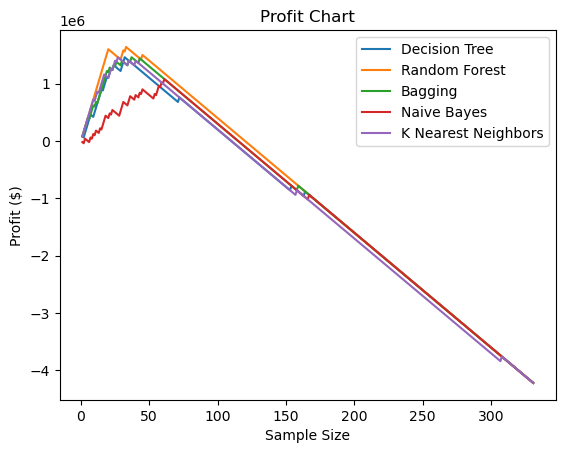

In [201]:
# Plot profit charts for all models
plt.plot(list(profit_dt.keys()), list(profit_dt.values()), label="Decision Tree")
plt.plot(list(profit_rf.keys()), list(profit_rf.values()), label="Random Forest")
plt.plot(list(profit_bg.keys()), list(profit_bg.values()), label="Bagging")
plt.plot(list(profit_nb.keys()), list(profit_nb.values()), label="Naive Bayes")
plt.plot(list(profit_knn.keys()), list(profit_knn.values()), label="K Nearest Neighbors")

plt.xlabel("Sample Size")
plt.ylabel("Profit ($)")
plt.legend()
plt.title("Profit Chart")

plt.show()

In [202]:
# PROFITS

print("Max Profit Decision Tree:", max(profit_dt.values()))
print("Max Profit Random Forest:", max(profit_rf.values()))
print("Max Profit Naive Bayes:", max(profit_nb.values()))
print("Max Profit K Nearest Neighbors:", max(profit_knn.values()))
print("Max Profit Bagging:", max(profit_bg.values()))

Max Profit Decision Tree: 1460000
Max Profit Random Forest: 1640000
Max Profit Naive Bayes: 1080000
Max Profit K Nearest Neighbors: 1460000
Max Profit Bagging: 1460000


The best model for this context is the Random Forest Model (around $1,640,000) as it performs the best out of all the models. The profit chart above shows that as the threshhold increases to a certain point, this model has the highest peak/profit.

**4.3 Using the model selected in 4.2, formulate clearly the investment strategy you will use to decide which players to invest in. The strategy should include the following:**

**a. Which model to use (along with corresponding parameters, such as number and type of models in bagging ensemble, number of K nearest neighbors, etc.)**

**b. Given your model’s estimated probability of induction, above what probability threshold to invest in a player’s memorabilia.**

**(5 points)**


In [203]:
# use dictionaries to store profits
threshold_profits_rf = {}

# Get unique probability thresholds from the DataFrames
unique_thresholds_rf = sorted(set(rf_prob_df['prob']))

# Calculate profit for each threshold
for threshold in unique_thresholds_rf:
    profit_rf = 0
    
    for i, row in rf_prob_df.iterrows():
        if row['prob'] >= threshold: 
            if row['Actual Class']:
                profit_rf += 80000
            else:
                profit_rf -= 20000
    
    threshold_profits_rf[threshold] = profit_rf
    
# Find the optimal threshold for the model
optimal_threshold_rf = max(threshold_profits_rf, key=threshold_profits_rf.get)

print("Optimal Threshold:")
print(f"Random Forest: {optimal_threshold_rf:.4f}")

Optimal Threshold:
Random Forest: 0.2300


a) We are using a Random Forest Model: Parameters include n_estimators = 100, max_features = 6, and random_state = 3

b) The threshold we will utilize is roughly 0.23 as can be seen above with the Random Forest model.

**4.4 Deploy your strategy to the test set**

First, generate predictions for players in the test set and then use these predictions to identify an advantageous probability threshold to use towards your future investments. Use `predict_proba` to get the probability of the predict class.

Hint: use previous homeworks to help with charts if you need it

     Probability  Actual
194         0.08   False
137         0.00   False
144         0.00   False
161         0.00   False
445         0.00   False
0.10164634146341464


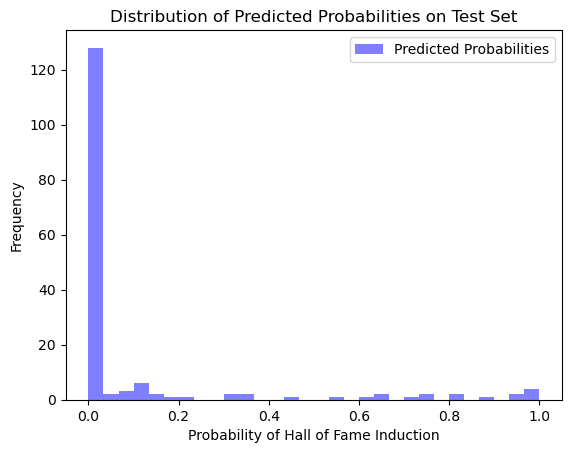

In [204]:
rf_model = RandomForestClassifier(n_estimators = 100, max_features = 6, random_state=3).fit(X_train, y_train)
predictions = rf_model.predict_proba(X_test)[:, 1]

# Create a DataFrame to store probabilities
rf_prob_test_df = pd.DataFrame({'Probability': predictions, 'Actual': y_test})

# Display the first few rows of the DataFrame
print(rf_prob_test_df.head())
print(rf_prob_test_df['Probability'].mean())

# Visualize the distribution of probabilities
plt.hist(predictions, bins=30, alpha=0.5, color='blue', label='Predicted Probabilities')
plt.xlabel('Probability of Hall of Fame Induction')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities on Test Set')
plt.legend()
plt.show()

**4.5 Print the list of players (along with their Example number) you will invest in, and report your profit. (10 points)**

In [205]:
# Identifying players to invest in based on the threshold probability
invest_players = rf_prob_test_df[rf_prob_test_df['Probability'] >= optimal_threshold_rf]

# Printing the list of players to invest in along with their Example numbers
print("   Players to Invest In:")
print("---------------------------")
print(invest_players)

# Calculating profit from the selected investments
total_profit = invest_players['Actual'].sum() * 80000 - (invest_players.shape[0] - invest_players['Actual'].sum()) * 20000
print("---------------------------")
print(f"Total Profit: ${total_profit:,.2f}")

   Players to Invest In:
---------------------------
     Probability  Actual
204         0.76    True
209         0.83    True
112         0.46    True
397         0.97    True
228         1.00    True
80          0.82    True
347         0.89    True
14          0.73    True
73          1.00    True
175         0.66    True
87          0.94    True
427         0.30    True
353         0.96    True
340         0.30    True
394         0.65    True
10          0.54   False
287         0.75    True
24          0.60   False
114         1.00    True
415         0.34   False
330         0.35   False
---------------------------
Total Profit: $1,280,000.00


## Attribute Descriptions

Field | Description
------|------------
league| N = National Basketball Association (NBA); A = American Basketball Association (ABA)
games|games played
minutes|minutes played
pts|points
offReb|offensive rebounds
defReb|defensive rebounds
reb|rebounds
asts|assists
stl|steals* (see below)
blk|blocks* (see below)
turnover|turnovers* (see below)
pf|Personal Fouls
fga|field goals attempted
fgm|field goals made
fta|free throws attempted
ftm|free throws made
tpa|three pointers attempted* (see below)
tpm|three pointers made* (see below)
totalSeasons|Total number of seasons played. This value is calculated as follows: "lastSeason - firstSeason + 1"
position|C = Center; F = Forward; G = Guard
firstSeason|First season played. The year corresponds to the first year of the season (i.e. a value of 2000 represents the 2000-2001 season). 
lastSeason|Last season played. The year corresponds to the first year of the season (i.e. a value of 2000 represents the 2000-2001 season). Note that 2004 (2004-2005 season) is the last year for which there is data. 
careerEnded|Boolean field for if the player's career has ended (1 if career has ended, 0 otherwise). This field was calculated as follows: if the "lastSeason" field is earlier than 2004, the value is 1, otherwise 0. Note that this calculation naively assumes that no players retired at the end of the 2004  season.
yrsRetired2004|The number of seasons that a player has been retired as of the 2004-2005 season.
class|A Boolean field showing whether or not a player was inducted to the Basketball Hall of Fame (HoF) as a player. This field has value 1 if the player has been inducted, and 0 otherwise.




* The NBA did not have three point shots until 1979
* Steals, Blocks and Turnovers were not recorded in the NBA until 1973

# COMPETITION

In [206]:
# My Profit: $3,040,000
# My Model: Random Forest Classifier
# My Model Hyperparamaters: random_state = 3, max_features = 7, max_depth = 4, n_estimators = 500

In [241]:
X_modified = X.drop(columns=features_to_remove)

# FEATURE ENGINERING: points per game
X_modified['points_per_game'] = X['pts'] / X['games']

In [242]:
# DATA

X_modified.head()

,games,minutes,pts,offReb,defReb,reb,asts,stl,blk,turnover,...,fta,ftm,tpa,totalSeasons,firstSeason,lastSeason,yrsRetired2004,league_A,Position_C,points_per_game
0,408.0,9825.0,5232.0,476.0,824.0,1300.0,866.0,265.0,175.0,700.0,...,1495.0,1125.0,153.0,9.0,1982.0,1990.0,14.0,0,0,12.823529
1,51.0,0.0,587.0,0.0,0.0,0.0,158.0,0.0,0.0,0.0,...,181.0,143.0,0.0,1.0,1949.0,1949.0,55.0,0,0,11.509804
2,265.0,0.0,1712.0,0.0,0.0,72.0,311.0,0.0,0.0,0.0,...,620.0,402.0,0.0,5.0,1946.0,1950.0,54.0,0,0,6.460377
3,133.0,2587.0,992.0,55.0,198.0,253.0,291.0,123.0,14.0,207.0,...,130.0,102.0,349.0,2.0,2003.0,2004.0,0.0,0,0,7.458647
4,8.0,28.0,7.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,...,5.0,3.0,0.0,1.0,2004.0,2004.0,0.0,0,0,0.875000


In [243]:
# Get columns until 'totalSeasons'
columns_until_total_seasons = X_modified.columns.get_loc('totalSeasons') + 1

# Replace 0's with NaN for selected columns
X_modified.iloc[:, :columns_until_total_seasons] = X_modified.iloc[:, :columns_until_total_seasons].replace(0, np.nan)

# Calculate the column-wise mean
column_means = X_modified.iloc[:, :columns_until_total_seasons].mean()

# Fill NaN values with column means
X_modified.iloc[:, :columns_until_total_seasons] = X_modified.iloc[:, :columns_until_total_seasons].fillna(column_means)

In [244]:
X_modified.head()

,games,minutes,pts,offReb,defReb,reb,asts,stl,blk,turnover,...,fta,ftm,tpa,totalSeasons,firstSeason,lastSeason,yrsRetired2004,league_A,Position_C,points_per_game
0,408.0,9825.00000,5232.0,476.000000,824.000000,1300.000000,866.000000,265.000000,175.000000,700.000000,...,1495.0,1125.0,153.000000,9.0,1982.0,1990.0,14.0,0,0,12.823529
1,51.0,7531.19426,587.0,415.740214,876.326797,1512.175556,158.000000,270.863333,149.099656,450.959375,...,181.0,143.0,273.967509,1.0,1949.0,1949.0,55.0,0,0,11.509804
2,265.0,7531.19426,1712.0,415.740214,876.326797,72.000000,311.000000,270.863333,149.099656,450.959375,...,620.0,402.0,273.967509,5.0,1946.0,1950.0,54.0,0,0,6.460377
3,133.0,2587.00000,992.0,55.000000,198.000000,253.000000,291.000000,123.000000,14.000000,207.000000,...,130.0,102.0,349.000000,2.0,2003.0,2004.0,0.0,0,0,7.458647
4,8.0,28.00000,7.0,415.740214,2.000000,2.000000,762.347368,270.863333,149.099656,1.000000,...,5.0,3.0,273.967509,1.0,2004.0,2004.0,0.0,0,0,0.875000


In [260]:
# Define the parameter grid to search through
param_grid = {
    'n_estimators': [50, 100, 500, 1000],
    'max_features': [3, 4, 5, 6, 7, 8, 9],
    'max_depth': [None, 2, 4, 6, 7, 8, 9, 10]
}

# Instantiate the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=3)

# Create the GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=10, scoring='roc_auc')

# Fit the grid search to your data
grid_search.fit(X_modified, y)

# Get the best parameters and best estimator found by GridSearchCV
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 4, 'max_features': 7, 'n_estimators': 500}


In [264]:
# X_modified.to_csv('CCdata.csv')

In [263]:
# Initialize and fit the Random Forest model on the entire dataset
rf_model_full = RandomForestClassifier(n_estimators = 500, max_depth = 4, max_features = 7, random_state = 3)
rf_model_full.fit(X_modified, y)

# Generate cross-validated predictions
predictions_full = cross_val_predict(rf_model_full, X_modified, y, cv=10, method='predict_proba')

# Create a DataFrame to store probabilities and actual class
rf_prob_full_df = pd.DataFrame({'Probability': predictions_full[:, 1], 'Actual': y})

# Calculate profit for each threshold
threshold_profits_full = {}
unique_thresholds_full = sorted(set(rf_prob_full_df['Probability']))

for threshold in unique_thresholds_full:
    profit_full = 0
    
    for i, row in rf_prob_full_df.iterrows():
        if row['Probability'] >= threshold: 
            if row['Actual']:
                profit_full += 80000
            else:
                profit_full -= 20000
    
    threshold_profits_full[threshold] = profit_full

# Find the optimal threshold for the model on the entire dataset
optimal_threshold_full = max(threshold_profits_full, key=threshold_profits_full.get)

print("Optimal Threshold on Entire Dataset:", optimal_threshold_full)

# Use the optimal threshold to identify players to invest in
invest_players_full = rf_prob_full_df[rf_prob_full_df['Probability'] >= optimal_threshold_full]

# Calculate total profit from the selected investments on the entire dataset
total_profit_full = invest_players_full['Actual'].sum() * 80000 - (invest_players_full.shape[0] - invest_players_full['Actual'].sum()) * 20000

print()

# Output the list of players to invest in along with their Example numbers
print("Players to Invest In (Entire Dataset):")
print("--------------------------------------")
print(invest_players_full)
print("--------------------------------------")
print(f"Total Profit (Entire Dataset): ${total_profit_full:,.2f}")

Optimal Threshold on Entire Dataset: 0.3808722781293303

Players to Invest In (Entire Dataset):
--------------------------------------
     Probability  Actual
6       0.867740    True
10      0.555992   False
14      0.824338    True
24      0.748535   False
35      0.873790    True
38      0.932611    True
46      0.531796   False
53      0.829746    True
73      0.987478    True
80      0.849763    True
87      0.914171    True
96      0.984067    True
104     0.911130    True
112     0.473355    True
114     0.988513    True
123     0.380872    True
142     0.795852    True
143     0.721645    True
168     0.900329    True
175     0.478082    True
176     0.755907    True
204     0.739904    True
209     0.702339    True
228     0.934998    True
244     0.498385    True
274     0.958967    True
287     0.797060    True
301     0.936396    True
309     0.817453    True
330     0.529956   False
340     0.414716    True
341     0.479681   False
347     0.891149    True
350     0.49819